In [1]:
import os
os.chdir("..")
import torch
from epilearn.models.Temporal.SIR import SIR, SEIR, SIS
from epilearn.models.SpatialTemporal.NetworkSIR import NetSIR
import epilearn.utils.utils as utils
from epilearn.data.dataset import UniversalDataset
from epilearn import visualize

### Generate random static graph

In [2]:
# generate random static graph
initial_graph = utils.get_random_graph(num_nodes=25, connect_prob=0.20)
initial_states = torch.zeros(25,3) # [S,I,R]
initial_states[:, 0] = 1
# set infected individual: 3
initial_states[3, 0] = 0
initial_states[3, 1] = 1
initial_states[10, 0] = 0
initial_states[10, 1] = 1

### Initialize NetworkSIR model and perform simulation based on the generated inital graph

In [3]:
model = NetSIR(num_nodes=initial_graph.shape[0], horizon=120, infection_rate=0.05, recovery_rate=0.05) # infection_rate, recover_rate, fixed_population
preds = model(initial_states, initial_graph, steps = None)

In [4]:
preds.argmax(2).shape

torch.Size([120, 25])

### Plot simulation result at a certain time point

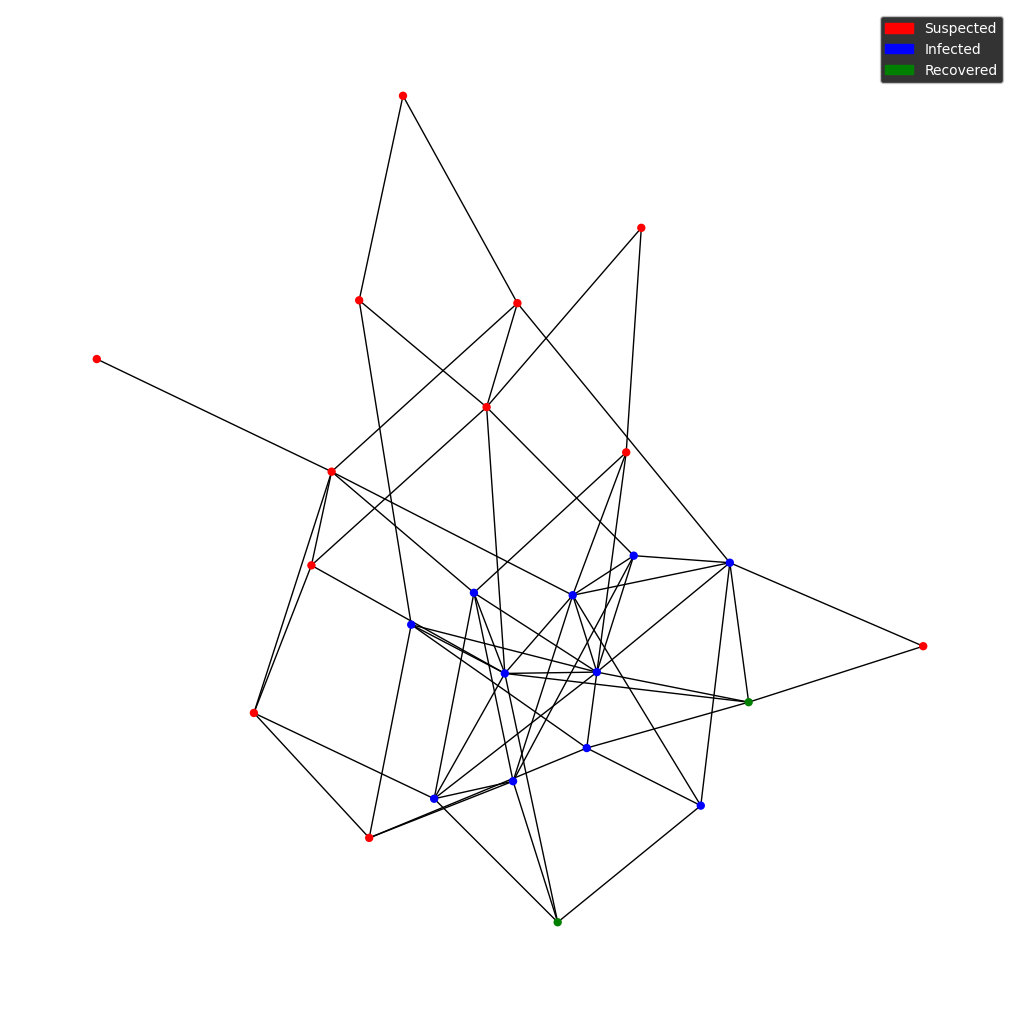

In [5]:
layout = visualize.plot_graph(preds.argmax(2)[15].detach().numpy(), initial_graph.to_sparse().indices().detach().numpy(), classes=['Suspected', 'Infected', 'Recovered'])

### Construct graph from feature

In [6]:
feature = torch.rand(10,20)
adj = torch.randint(10,100, (10,10))
graph1 = utils.get_graph_from_features(features=feature, adj=None)
graph2 = utils.get_graph_from_features(features=feature, adj=adj)

In [7]:
graph1

tensor([[1.0000, 0.6683, 0.7352, 0.6527, 0.6339, 0.5774, 0.7807, 0.7357, 0.7074,
         0.6202],
        [0.6683, 1.0000, 0.7750, 0.8240, 0.8190, 0.7722, 0.7422, 0.7961, 0.8360,
         0.7574],
        [0.7352, 0.7750, 1.0000, 0.7715, 0.8065, 0.7436, 0.7493, 0.7314, 0.7279,
         0.8216],
        [0.6527, 0.8240, 0.7715, 1.0000, 0.7865, 0.7135, 0.7354, 0.8496, 0.8146,
         0.6379],
        [0.6339, 0.8190, 0.8065, 0.7865, 1.0000, 0.7367, 0.7860, 0.6695, 0.7714,
         0.7073],
        [0.5774, 0.7722, 0.7436, 0.7135, 0.7367, 1.0000, 0.7943, 0.7851, 0.8157,
         0.7065],
        [0.7807, 0.7422, 0.7493, 0.7354, 0.7860, 0.7943, 1.0000, 0.7658, 0.8626,
         0.6065],
        [0.7357, 0.7961, 0.7314, 0.8496, 0.6695, 0.7851, 0.7658, 1.0000, 0.8607,
         0.6974],
        [0.7074, 0.8360, 0.7279, 0.8146, 0.7714, 0.8157, 0.8626, 0.8607, 1.0000,
         0.7468],
        [0.6202, 0.7574, 0.8216, 0.6379, 0.7073, 0.7065, 0.6065, 0.6974, 0.7468,
         1.0000]])

In [8]:
graph2

tensor([[0.0278, 0.0334, 0.0121, 0.0344, 0.0373, 0.0222, 0.0355, 0.0077, 0.0165,
         0.0063],
        [0.0068, 0.0109, 0.0080, 0.0275, 0.0315, 0.0143, 0.0265, 0.0221, 0.0220,
         0.0108],
        [0.0432, 0.0088, 0.0385, 0.0093, 0.0310, 0.0149, 0.0141, 0.0166, 0.0140,
         0.0205],
        [0.0096, 0.0201, 0.0103, 0.0149, 0.0167, 0.0549, 0.0433, 0.0181, 0.0134,
         0.0074],
        [0.0072, 0.0210, 0.0172, 0.0090, 0.0222, 0.0097, 0.0084, 0.0092, 0.0129,
         0.0221],
        [0.0156, 0.0123, 0.0087, 0.0152, 0.0567, 0.0169, 0.0378, 0.0231, 0.0138,
         0.0505],
        [0.0166, 0.0109, 0.0115, 0.0087, 0.0151, 0.0139, 0.0133, 0.0139, 0.0151,
         0.0066],
        [0.0108, 0.0249, 0.0075, 0.0121, 0.0100, 0.0253, 0.0137, 0.0161, 0.0261,
         0.0072],
        [0.0071, 0.0094, 0.0560, 0.0089, 0.0234, 0.0094, 0.0157, 0.0094, 0.0667,
         0.0197],
        [0.0113, 0.0079, 0.0187, 0.0103, 0.0322, 0.0094, 0.0078, 0.0085, 0.0191,
         0.0115]])